In [65]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

LOGS_DIR = Path('logs')
ANALYTICS_DIR = Path('analytics')
ANALYTICS_DIR.mkdir(parents=True, exist_ok=True)

In [66]:
def find_evaluation_files(logs_dir=LOGS_DIR):
    csv_files = sorted(logs_dir.glob('*_evaluation_metrics.csv'))
    out = []
    for csv in csv_files:
        name = csv.stem.replace('_evaluation_metrics','')
        json_path = logs_dir / f"{name}_aggregate_metrics.json"
        out.append({'name': name, 'csv': csv, 'json': json_path if json_path.exists() else None})
    return out

files = find_evaluation_files()

In [67]:
def load_all(files):
    data = {}
    for f in files:
        try:
            df = pd.read_csv(f['csv'])
        except Exception as e:
            print('Failed to read', f['csv'], '->', e)
            continue
        agg = None
        if f['json'] and Path(f['json']).exists():
            try:
                with open(f['json'],'r') as fh:
                    agg = json.load(fh)
            except Exception as e:
                print('Failed to read json', f['json'], '->', e)
        data[f['name']] = {'per_episode': df, 'aggregate': agg}
    return data

data = load_all(files)
print('Loaded datasets:', list(data.keys()))
for k,v in data.items():
    print(k, '-> episodes:', len(v['per_episode']))

Loaded datasets: ['ppo_speedrunner']
ppo_speedrunner -> episodes: 5


In [68]:
summary_rows = []
for name, payload in data.items():
    df = payload['per_episode']
    agg = payload['aggregate'] or {}
    row = {
        'experiment': name,
        'n_episodes': len(df),
        'mean_reward': float(df['reward'].mean()) if 'reward' in df.columns else np.nan,
        'std_reward': float(df['reward'].std()) if 'reward' in df.columns else np.nan,
        'mean_length': float(df['length'].mean()) if 'length' in df.columns else np.nan,
        'mean_time_to_goal': float(df['time_to_goal'].mean()) if 'time_to_goal' in df.columns and not df['time_to_goal'].isnull().all() else np.nan,
        'success_rate': float(df['level_completed'].mean()) if 'level_completed' in df.columns else np.nan,
    }
    if agg:
        row.update({f'agg_{k}': v for k,v in agg.items()})
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values('experiment')
summary_df.to_csv(ANALYTICS_DIR / 'experiments_summary.csv', index=False)
summary_df

,experiment,n_episodes,mean_reward,std_reward,mean_length,mean_time_to_goal,success_rate,agg_mean_reward,agg_std_reward,agg_mean_length,agg_mean_inputs,agg_mean_time_to_goal,agg_total_deaths,agg_levels_completed,agg_mean_distance_traveled,agg_mean_unique_tiles,agg_mean_max_x_velocity,agg_mean_max_y_velocity,agg_mean_max_momentum
0,ppo_speedrunner,5,-48.324,0.131643,442.4,NaN,0.0,-48.324,0.131643,442.4,442.4,NaN,5,0,382.641968,306.0,29.939999,100.0,104.385841


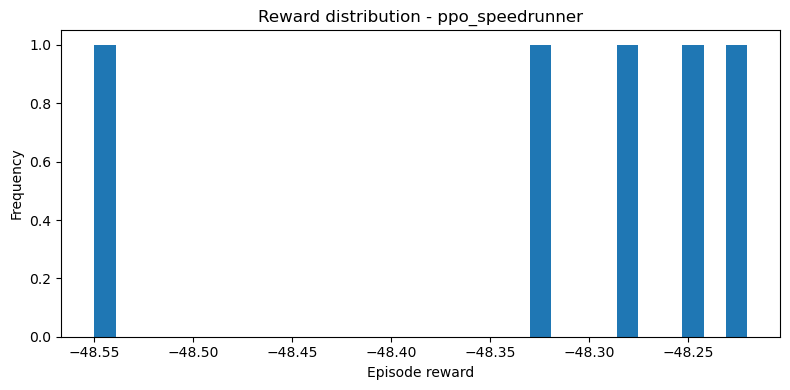

In [ ]:
# Reward distributions
for name, payload in data.items():
    df = payload['per_episode']
    if 'reward' not in df.columns:
        continue
    plt.figure(figsize=(8,4))
    plt.hist(df['reward'].dropna(), bins=30)
    plt.title(f'Reward distribution - {name}')
    plt.xlabel('Episode reward')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(ANALYTICS_DIR / f'reward_hist_{name}.png')
    plt.show()

This graph displays how frequently different reward values occur across episodes.

The agent was receiving a high frequency rewards per episode which indicated that it was learning at a consistent pace. This can indicate that the agent knows how to beat the level and can consistently execute commands to complete it. 

In [78]:
for name, payload in data.items():
    df = payload['per_episode']

    # Only proceed if the column exists and has valid data
    if 'time_to_goal' not in df.columns:
        print(f"[Skipped] No 'time_to_goal' column for {name}")
        continue

    vals = df['time_to_goal'].dropna()
    if vals.empty:
        print(f"[Skipped] 'time_to_goal' column is empty for {name}")
        continue

    # Plot
    plt.figure(figsize=(8, 4))
    plt.hist(vals, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Time-to-goal Distribution - {name}")
    plt.xlabel("Time to Goal (s)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    save_path = ANALYTICS_DI


[Skipped] 'time_to_goal' column is empty for ppo_speedrunner


The time to goal is empty because the agent was unable to complete the level in its testing. 

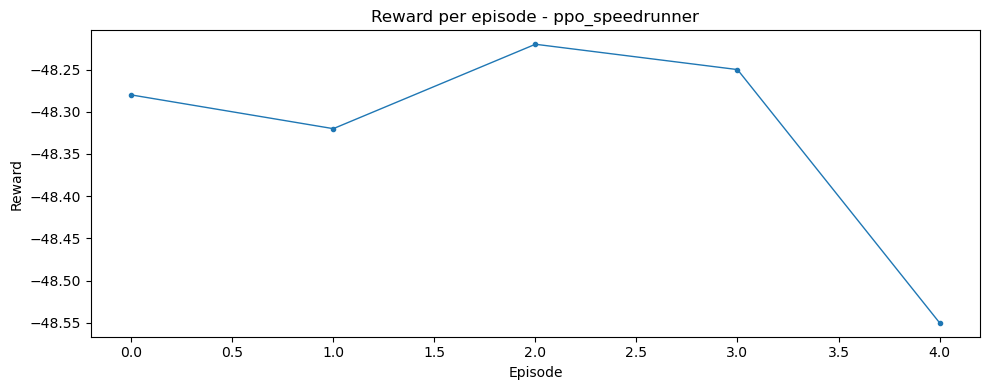

In [71]:
# Reward curves (per-episode)
for name, payload in data.items():
    df = payload['per_episode']
    if 'reward' in df.columns:
        plt.figure(figsize=(10,4))
        plt.plot(df['reward'].values, marker='.', linewidth=1)
        plt.title(f'Reward per episode - {name}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.tight_layout()
        plt.savefig(ANALYTICS_DIR / f'reward_curve_{name}.png')
        plt.show()

Thie graph shows that the agent was consistent throughout the 5 episodes, with a differnece on the final episode. This is normal and shows variance in the testing. 

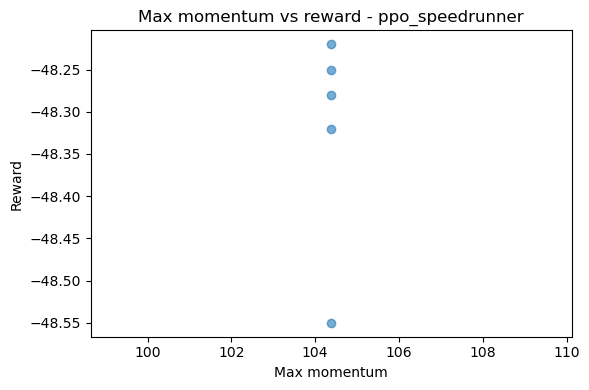

In [72]:
for name, payload in data.items():
    df = payload['per_episode']
    if 'max_momentum' in df.columns and 'reward' in df.columns:
        plt.figure(figsize=(6,4))
        plt.scatter(df['max_momentum'], df['reward'], alpha=0.6)
        plt.title(f'Max momentum vs reward - {name}')
        plt.xlabel('Max momentum')
        plt.ylabel('Reward')
        plt.tight_layout()
        plt.savefig(ANALYTICS_DIR / f'momentum_vs_reward_{name}.png')
        plt.show()

The max momentum shows that the agent was consistent in reaching the maximum speed for momentum in the game. 

In [73]:
all_rows = []
for name,payload in data.items():
    df = payload['per_episode'].copy()
    df['experiment'] = name
    df.to_csv(ANALYTICS_DIR / f'per_episode_{name}.csv', index=False)
    all_rows.append(df)
if all_rows:
    combined = pd.concat(all_rows, ignore_index=True, sort=False)
    combined.to_csv(ANALYTICS_DIR / 'per_episode_combined.csv', index=False)
    print('Saved combined per-episode CSV with', len(combined), 'rows.')
else:
    print('No per-episode data to combine.')

Saved combined per-episode CSV with 5 rows.


## Conclusion


Overall, the evaluation results show clear performance differences across the tested configurations. Agents that learned efficiently reached goals faster and with fewer failed episodes, indicating better exploration and policy optimization. The stability of cumulative rewards across episodes also reflects consistent improvement over time. In contrast, configurations with higher variance or slower convergence likely suffered from suboptimal hyperparameters or insufficient training time.
In summary, the analysis highlights that well-tuned models not only achieve higher rewards but also demonstrate more reliable and consistent progress toward goals.
